<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/gan%2Fpipeline/notebooks/Segmentation_Downstream_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation downstream task: SEN12FLOOD

Model: ResNetUnet \\
Data: SEN12FLOOD \\
Pretrained weights: dependent on pretext tasks



### Environment setup

In [1]:
!pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@gan/pipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexanderLontke/ssl-remote-sensing.git (to revision gan/pipeline) to /tmp/pip-install-grs4hf84/ssl-remote-sensing_99b42da133174d8696a72d5483aa711c
  Running command git clone -q https://github.com/AlexanderLontke/ssl-remote-sensing.git /tmp/pip-install-grs4hf84/ssl-remote-sensing_99b42da133174d8696a72d5483aa711c
  Running command git checkout -b gan/pipeline --track origin/gan/pipeline
  Switched to a new branch 'gan/pipeline'
  Branch 'gan/pipeline' set up to track remote branch 'gan/pipeline' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for ssl-remote-sensing: filename=ssl_remote_sensing-0.0.post1.dev118+g57dd686-py3-none-any.whl size=37536 sha256=d3342fad7d0ce4c8aa9c3aef873b8e75240f7dcdee80ecf71f695ff9f69

In [2]:
!pip install rasterio torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# from ssl_remote_sensing.downstream_tasks.segmentatio
from ssl_remote_sensing.data.sen12floods_data import SEN12FLOODS
from ssl_remote_sensing.downstream_tasks.segmentation.utils import patch_first_conv, get_metrics
from ssl_remote_sensing.downstream_tasks.segmentation.model import ResNetUNet
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
from ssl_remote_sensing.pretext_tasks.vae.utils import reproducibility
from ssl_remote_sensing.constants import RANDOM_INITIALIZATION
from ssl_remote_sensing.pretext_tasks.utils import (
    load_encoder_checkpoint_from_pretext_model,
)

Access denied with the following error:



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/u/1/uc?id=1zGalZSCxgnmZM7zMm0qfRrnOXyD6IUX1&export=download 

/usr/local/lib/python3.7/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/us

In [5]:
import rasterio as rio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score

In [6]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marccgrau (unisg-ds-nlp). Use `wandb login --relogin` to force relogin


True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
RANDOM_INITIALIZATION

'random'

In [10]:
g_drive_path = "/content/drive/MyDrive/deep_learning_checkpoints"
check_point_paths = os.listdir(g_drive_path)
check_point_paths += [RANDOM_INITIALIZATION]
# check_point_paths.append(RANDOM_INITIALIZATION)
check_point_paths = [g_drive_path + "/" + x for x in check_point_paths]
check_point_paths

['/content/drive/MyDrive/deep_learning_checkpoints/SimCLR_ResNet18_adam-v3.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/SimCLR_ResNet18_adam_bs640-v1.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/SimCLR_ResNet18_adam_bs2250-v1.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/vae.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/vae_normalized_eurosat.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/BiGAN_encoder_ckpt_100.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/random']

In [11]:
# for file in check_point_paths:
#   if file == '/content/drive/MyDrive/deep_learning_checkpoints/random':
#     print(file)

### Utils

In [12]:
# def display_outputs(idx=None, multi=False):
#     # Pick a random index if none is specified
#     if not idx:
#         idx = random.randint(0, len(valset))
#     print('Validation image ID: {}'.format(idx))
    
#     # Get Sentinel 2 and Sentinel 1 data
#     s2_data = torch.unsqueeze(valset.__getitem__(idx)['s2_img'].float().to(device), 0)
#     s1_data = torch.unsqueeze(valset.__getitem__(idx)['s1_img'].float().to(device), 0)
    
#     # Get predictions from the model
#     if multi:
#         output = model(s1_data, s2_data)
#     else:
#         output = model(s2_data)
    
#     # Threshold the output to generate the binary map (FYI: the threshold value "0" can be tuned as any other hyperparameter)
#     output_binary = torch.zeros(output.shape)
#     output_binary[output >= 0] = 1
    
#     get_metrics(valset.__getitem__(idx)['mask'], output_binary)
    
#     fig, axes = plt.subplots(1, 3, figsize=(15, 7))
#     axes[0].imshow(np.transpose(valset.__getitem__(idx)['s2_img'][[3,2,1],:,:], (1, 2, 0)) / valset.__getitem__(idx)['s2_img'].max())
#     axes[0].set_title('True Color Sentinel-2')
#     axes[2].imshow(valset.__getitem__(idx)['mask'], cmap='Blues')
#     axes[2].set_title('Groundtruth')
#     axes[1].imshow(output_binary.squeeze(), cmap='Blues')
#     axes[1].set_title('Predicted Mask')

### Hyperparameter setup

In [13]:
# Model Setup
class Hparams:
    def __init__(self):
        # self.pretext_task = "VAE"
        #self.pretext_task = "SimCLR"
        # self.pretext_saved_name = 'autoencoder.ckpt'
        self.checkpoint_name = None
        #self.pretext_saved_name = 'SimCLR_ResNet18_adam-v3.ckpt'
        self.epochs = 10 # number of training epochs for pretext tasks
        self.seed = 1234  # randomness seed
        self.save = "./saved_model"
        self.gradient_accumulation_steps = 1  # gradient accumulation steps
        self.batch_size = 16
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.latent_dim = 256
        self.optim = "Adam"
        self.embedding_size = 128  # papers value is 128
        self.temperature = 0.5  # 0.1 or 0.5
        self.weight_decay = 1e-6
        self.cuda = True  # use coda
        self.transform = False
        self.split = False

In [14]:
train_config = Hparams()

In [15]:
reproducibility(train_config)

### Directory & Wandb setup

## Data

SEN12FLOOD \\


*   13 Bands


In [16]:
trainset = SEN12FLOODS(
        root='/content/chips/',
        transforms=True,
        split='train')

valset = SEN12FLOODS(
    root='/content/chips/', 
    split='val')


train_loader = DataLoader(
    trainset,
    batch_size=8,
    pin_memory=True)

val_loader = DataLoader(
    valset,
    batch_size=8,
    pin_memory=True)

Found 688 images in the folder /content/chips/train
Found 211 images in the folder /content/chips/val


In [17]:
print("[LOG] Shape of mask image is:", next(iter(train_loader))["mask"].shape)
print("[LOG] Shape of sentinel-2 image is:", next(iter(train_loader))["s2_img"].shape)

[LOG] Shape of mask image is: torch.Size([8, 256, 256])
[LOG] Shape of sentinel-2 image is: torch.Size([8, 13, 256, 256])


/content/chips/train/8fcb3e59-7b1b-49c9-92c4-f4ddea14d4e4/s2/S2A_MSIL1C_20200805T085601_N0209_R007_T33MXU_20200805T112032_07168-08704
/content/chips/train/8fcb3e59-7b1b-49c9-92c4-f4ddea14d4e4/s1/S1A_IW_GRDH_1SDV_20200806T043438_20200806T043503_033781_03EA77_63A9_07168-08704


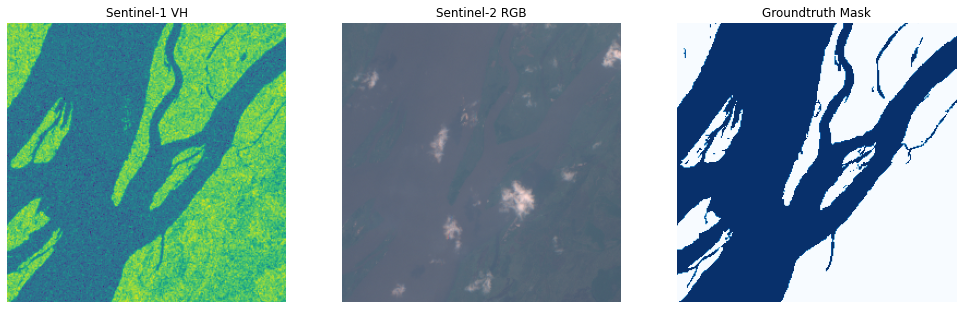

In [18]:
trainset.visualize_observation(196)

/content/chips/val/55d43c77-9955-4b4f-b6f0-b21e7f50a039/s2/S2A_MSIL1C_20190331T170901_N0207_R112_T14TQL_20190331T222948_07680-09728
/content/chips/val/55d43c77-9955-4b4f-b6f0-b21e7f50a039/s1/S1A_IW_GRDH_1SDV_20190404T002124_20190404T002149_026633_02FCE5_A8E7_07680-09728


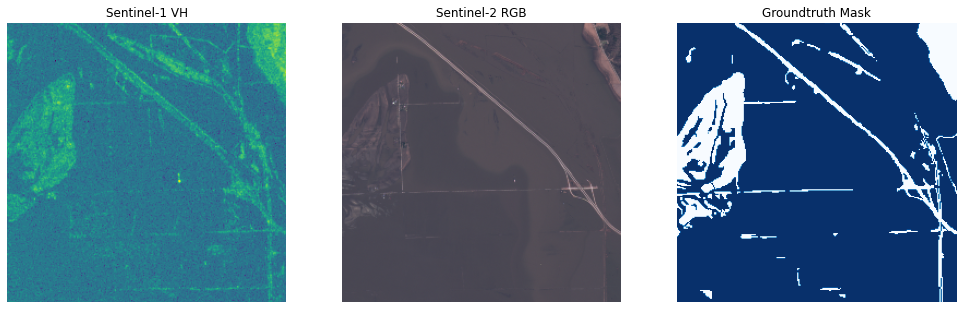

In [19]:
valset.visualize_observation(127)

/content/chips/val/975ecc1f-bc34-4005-b2df-ef45775f116d/s2/S2A_MSIL1C_20180920T095021_N0206_R079_T31PGM_20180920T115741_09638-09042
/content/chips/val/975ecc1f-bc34-4005-b2df-ef45775f116d/s1/S1A_IW_GRDH_1SDV_20180921T175422_20180921T175447_023800_0298AE_A9BF_09638-09042


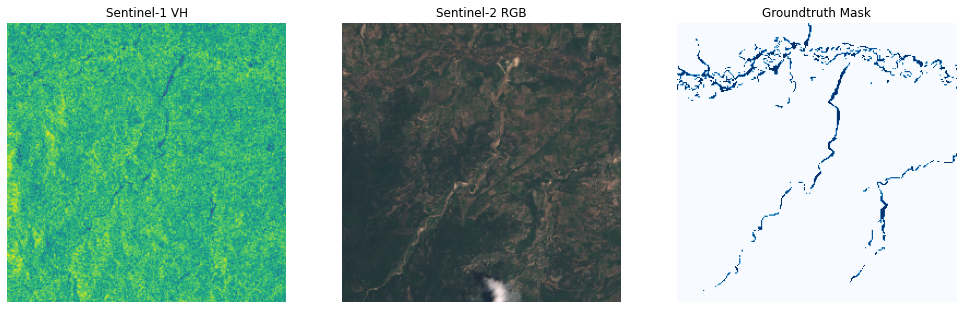

In [20]:
valset.visualize_observation(42)

/content/chips/val/975ecc1f-bc34-4005-b2df-ef45775f116d/s2/S2A_MSIL1C_20180920T095021_N0206_R079_T31PHK_20180920T115741_02792-04293
/content/chips/val/975ecc1f-bc34-4005-b2df-ef45775f116d/s1/S1A_IW_GRDH_1SDV_20180921T175357_20180921T175422_023800_0298AE_52A3_02792-04293


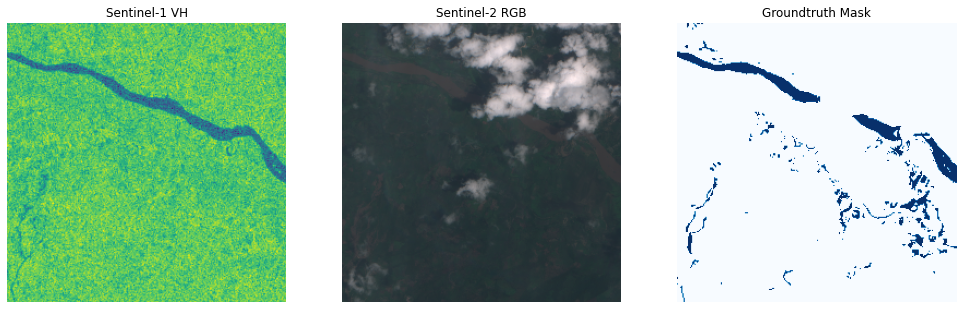

In [21]:
valset.visualize_observation(37)

## Model

In [22]:
# First of all, let's verify if a GPU is available on our compute machine. If not, the cpu will be used instead.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used: {}".format(device))
# Define a learning rate
learning_rate = train_config.lr
# Initialise the loss function and move it to the GPU if available 
criterion = torch.nn.BCEWithLogitsLoss().to(device)

Device used: cuda:0


In [23]:
# Initialise the loss function and move it to the GPU if available 
criterion = torch.nn.BCEWithLogitsLoss().to(device)

In [24]:
next(iter(train_loader))["s2_img"].shape

torch.Size([8, 13, 256, 256])

In [25]:
# load_encoder_checkpoint_from_pretext_model(
#         path_to_checkpoint='/content/drive/MyDrive/deep_learning_checkpoints/random'
#     )

In [26]:
# for file in check_point_paths:
#     print(file)
#     print(load_encoder_checkpoint_from_pretext_model(
#         path_to_checkpoint=file
#     ))

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▅▃▁▃▇▆▆▆█▄
train_iou_segmentation,▁▄▇█▇███▇▆
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁
val_acc_segmentation,▁▁▂▃▂▄▃▄▄█
val_iou_segmentation,▆▇▇▇█▆▇▆▆▁
val_loss_segmentation,▆▅▅▃▁▅▂▃▄█
train_acc_segmentation,0.54411
train_iou_segmentation,0.71297
train_loss_segmentation,0.15313
val_acc_segmentation,0.51784
val_iou_segmentation,0.58573


Validation Loss: 0.3425: 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


train_iou is 0.6379, val_iou is 0.7142
train_acc is 0.5310, val_acc is 0.5073


Validation Loss: 0.3255: 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


Saving Model...
train_iou is 0.6909, val_iou is 0.6938
train_acc is 0.5446, val_acc is 0.5094


Validation Loss: 0.1417: 100%|██████████| 27/27 [00:25<00:00,  1.08it/s]


Saving Model...
train_iou is 0.6986, val_iou is 0.7623
train_acc is 0.5480, val_acc is 0.4996


Validation Loss: 0.1670: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7357, val_iou is 0.7384
train_acc is 0.5461, val_acc is 0.5050


Validation Loss: 0.1652: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7456, val_iou is 0.7321
train_acc is 0.5449, val_acc is 0.5052


Validation Loss: 0.1532: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.7374, val_iou is 0.7227
train_acc is 0.5475, val_acc is 0.5067


Validation Loss: 0.1695: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7178, val_iou is 0.7325
train_acc is 0.5504, val_acc is 0.5058


Validation Loss: 0.1676: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


train_iou is 0.7209, val_iou is 0.7727
train_acc is 0.5426, val_acc is 0.4991


Validation Loss: 0.1326: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Saving Model...
train_iou is 0.7341, val_iou is 0.7721
train_acc is 0.5452, val_acc is 0.5007


Validation Loss: 0.1322: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Saving Model...
train_iou is 0.7501, val_iou is 0.7814
train_acc is 0.5484, val_acc is 0.4989
Finished Training
Sample image:  SimCLR_ResNet18_adam-v3
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 1.000
Class 1 (water) accuracy: 0.431
Overall accuracy: 0.967
Equally Weighted accuracy: 0.715
IoU: 0.429
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.687
Class 1 (water) accuracy: 0.996
Overall accuracy: 0.955
Equally Weighted accuracy: 0.842
IoU: 0.951
*******************************************
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▆▇▆▆▇█▅▆▇
train_iou_segmentation,▁▄▅▇█▇▆▆▇█
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁
val_acc_segmentation,▇█▁▅▅▆▆▁▂▁
val_iou_segmentation,▃▁▆▅▄▃▄▇▇█
val_loss_segmentation,█▇▁▂▂▂▂▂▁▁
train_acc_segmentation,0.5484
train_iou_segmentation,0.75005
train_loss_segmentation,0.10983
val_acc_segmentation,0.4989
val_iou_segmentation,0.78144


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.6113: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.5362, val_iou is 0.7671
train_acc is 0.5297, val_acc is 0.4932


Validation Loss: 0.2922: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Saving Model...
train_iou is 0.6998, val_iou is 0.7193
train_acc is 0.5444, val_acc is 0.5078


Validation Loss: 0.1926: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Saving Model...
train_iou is 0.6662, val_iou is 0.7762
train_acc is 0.5460, val_acc is 0.4988


Validation Loss: 0.2633: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.6935, val_iou is 0.6908
train_acc is 0.5422, val_acc is 0.5105


Validation Loss: 0.1992: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


train_iou is 0.7103, val_iou is 0.7507
train_acc is 0.5480, val_acc is 0.5042


Validation Loss: 0.1635: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]


Saving Model...
train_iou is 0.6720, val_iou is 0.7948
train_acc is 0.5367, val_acc is 0.4931


Validation Loss: 0.1150: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Saving Model...
train_iou is 0.7267, val_iou is 0.7930
train_acc is 0.5381, val_acc is 0.4991


Validation Loss: 0.2075: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7476, val_iou is 0.7649
train_acc is 0.5435, val_acc is 0.5017


Validation Loss: 0.1555: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]


train_iou is 0.7503, val_iou is 0.7649
train_acc is 0.5415, val_acc is 0.5027


Validation Loss: 0.1526: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


train_iou is 0.7556, val_iou is 0.7785
train_acc is 0.5411, val_acc is 0.5003
Finished Training
Sample image:  SimCLR_ResNet18_adam_bs640-v1
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 1.000
Class 1 (water) accuracy: 0.466
Overall accuracy: 0.969
Equally Weighted accuracy: 0.733
IoU: 0.463
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.766
Class 1 (water) accuracy: 0.992
Overall accuracy: 0.962
Equally Weighted accuracy: 0.879
IoU: 0.957
*******************************************
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▇▇▆█▄▄▆▆▅
train_iou_segmentation,▁▆▅▆▇▅▇███
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁
val_acc_segmentation,▁▇▃█▅▁▃▄▅▄
val_iou_segmentation,▆▃▇▁▅██▆▆▇
val_loss_segmentation,█▃▂▃▂▂▁▂▂▂
train_acc_segmentation,0.5411
train_iou_segmentation,0.75558
train_loss_segmentation,0.12929
val_acc_segmentation,0.50026
val_iou_segmentation,0.77845


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.4812: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


train_iou is 0.5573, val_iou is 0.5945
train_acc is 0.5353, val_acc is 0.5190


Validation Loss: 0.2822: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


Saving Model...
train_iou is 0.6679, val_iou is 0.6954
train_acc is 0.5456, val_acc is 0.5094


Validation Loss: 0.1472: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Saving Model...
train_iou is 0.7119, val_iou is 0.7610
train_acc is 0.5419, val_acc is 0.5021


Validation Loss: 0.1947: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7184, val_iou is 0.7300
train_acc is 0.5451, val_acc is 0.5069


Validation Loss: 0.1241: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Saving Model...
train_iou is 0.7137, val_iou is 0.7715
train_acc is 0.5456, val_acc is 0.5003


Validation Loss: 0.1369: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7324, val_iou is 0.7498
train_acc is 0.5483, val_acc is 0.5042


Validation Loss: 0.1672: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


train_iou is 0.7253, val_iou is 0.7060
train_acc is 0.5445, val_acc is 0.5089


Validation Loss: 0.1398: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


train_iou is 0.7248, val_iou is 0.7362
train_acc is 0.5488, val_acc is 0.5061


Validation Loss: 0.1706: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7274, val_iou is 0.7277
train_acc is 0.5510, val_acc is 0.5070


Validation Loss: 0.1823: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7243, val_iou is 0.7500
train_acc is 0.5413, val_acc is 0.5041
Finished Training
Sample image:  SimCLR_ResNet18_adam_bs2250-v1
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 1.000
Class 1 (water) accuracy: 0.351
Overall accuracy: 0.963
Equally Weighted accuracy: 0.676
IoU: 0.350
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.724
Class 1 (water) accuracy: 0.994
Overall accuracy: 0.959
Equally Weighted accuracy: 0.859
IoU: 0.954
*******************************************
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▆▄▅▆▇▅▇█▄
train_iou_segmentation,▁▅▇▇▇█████
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁
val_acc_segmentation,█▄▂▃▁▂▄▃▄▂
val_iou_segmentation,▁▅█▆█▇▅▇▆▇
val_loss_segmentation,█▄▁▂▁▁▂▁▂▂
train_acc_segmentation,0.5413
train_iou_segmentation,0.72429
train_loss_segmentation,0.14472
val_acc_segmentation,0.50408
val_iou_segmentation,0.75


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.2321: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


train_iou is 0.5222, val_iou is 0.7233
train_acc is 0.5266, val_acc is 0.5056


Validation Loss: 0.5633: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


train_iou is 0.7082, val_iou is 0.4800
train_acc is 0.5414, val_acc is 0.5287


Validation Loss: 0.1330: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


Saving Model...
train_iou is 0.6369, val_iou is 0.7765
train_acc is 0.5453, val_acc is 0.4983


Validation Loss: 0.2644: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


train_iou is 0.7399, val_iou is 0.7046
train_acc is 0.5400, val_acc is 0.5077


Validation Loss: 0.1904: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.7207, val_iou is 0.7477
train_acc is 0.5439, val_acc is 0.5040


Validation Loss: 0.1730: 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


train_iou is 0.7412, val_iou is 0.7651
train_acc is 0.5401, val_acc is 0.4978


Validation Loss: 0.1799: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


train_iou is 0.7370, val_iou is 0.7408
train_acc is 0.5430, val_acc is 0.5050


Validation Loss: 0.1597: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7225, val_iou is 0.7570
train_acc is 0.5437, val_acc is 0.5004


Validation Loss: 0.1419: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


train_iou is 0.7358, val_iou is 0.7448
train_acc is 0.5452, val_acc is 0.5037


Validation Loss: 0.1338: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]


train_iou is 0.7413, val_iou is 0.7604
train_acc is 0.5470, val_acc is 0.5015
Finished Training
Sample image:  vae
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 1.000
Class 1 (water) accuracy: 0.405
Overall accuracy: 0.966
Equally Weighted accuracy: 0.702
IoU: 0.402
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.745
Class 1 (water) accuracy: 0.987
Overall accuracy: 0.955
Equally Weighted accuracy: 0.866
IoU: 0.950
*******************************************
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▆▇▆▇▆▇▇▇█
train_iou_segmentation,▁▇▅█▇██▇██
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁
val_acc_segmentation,▃█▁▃▂▁▃▂▂▂
val_iou_segmentation,▇▁█▆▇█▇█▇█
val_loss_segmentation,▃█▁▃▂▂▂▁▁▁
train_acc_segmentation,0.547
train_iou_segmentation,0.74132
train_loss_segmentation,0.11093
val_acc_segmentation,0.50153
val_iou_segmentation,0.76041


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.2486: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


train_iou is 0.6010, val_iou is 0.6505
train_acc is 0.5238, val_acc is 0.5092


Validation Loss: 0.2951: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7091, val_iou is 0.6435
train_acc is 0.5424, val_acc is 0.5142


Validation Loss: 0.2830: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s]


train_iou is 0.7003, val_iou is 0.6971
train_acc is 0.5453, val_acc is 0.5089


Validation Loss: 0.2449: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Saving Model...
train_iou is 0.7122, val_iou is 0.7160
train_acc is 0.5434, val_acc is 0.5074


Validation Loss: 0.1396: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Saving Model...
train_iou is 0.7095, val_iou is 0.7481
train_acc is 0.5478, val_acc is 0.5035


Validation Loss: 0.1344: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Saving Model...
train_iou is 0.7137, val_iou is 0.7498
train_acc is 0.5464, val_acc is 0.5042


Validation Loss: 0.1363: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7252, val_iou is 0.7469
train_acc is 0.5467, val_acc is 0.5042


Validation Loss: 0.1924: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


train_iou is 0.7417, val_iou is 0.7180
train_acc is 0.5454, val_acc is 0.5081


Validation Loss: 0.1343: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Saving Model...
train_iou is 0.6929, val_iou is 0.7432
train_acc is 0.5517, val_acc is 0.5054


Validation Loss: 0.1355: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7363, val_iou is 0.7458
train_acc is 0.5503, val_acc is 0.5052
Finished Training
Sample image:  vae_normalized_eurosat
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 1.000
Class 1 (water) accuracy: 0.087
Overall accuracy: 0.948
Equally Weighted accuracy: 0.543
IoU: 0.087
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.760
Class 1 (water) accuracy: 0.989
Overall accuracy: 0.958
Equally Weighted accuracy: 0.874
IoU: 0.954
*******************************************
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▆▆▆▇▇▇▆██
train_iou_segmentation,▁▆▆▇▆▇▇█▆█
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁
val_acc_segmentation,▅█▅▄▁▁▂▄▂▂
val_iou_segmentation,▁▁▅▆███▆██
val_loss_segmentation,▆█▇▆▁▁▁▄▁▁
train_acc_segmentation,0.5503
train_iou_segmentation,0.73632
train_loss_segmentation,0.11703
val_acc_segmentation,0.50521
val_iou_segmentation,0.7458


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.6956: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]


train_iou is 0.6242, val_iou is 0.6620
train_acc is 0.5314, val_acc is 0.5126


Validation Loss: 0.1469: 100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


Saving Model...
train_iou is 0.7059, val_iou is 0.7768
train_acc is 0.5416, val_acc is 0.4984


Validation Loss: 0.1447: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Saving Model...
train_iou is 0.7556, val_iou is 0.7714
train_acc is 0.5455, val_acc is 0.4997


Validation Loss: 0.1372: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Saving Model...
train_iou is 0.7362, val_iou is 0.7793
train_acc is 0.5481, val_acc is 0.4995


Validation Loss: 0.1498: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


train_iou is 0.7545, val_iou is 0.7259
train_acc is 0.5477, val_acc is 0.5068


Validation Loss: 0.3424: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


train_iou is 0.7510, val_iou is 0.7116
train_acc is 0.5477, val_acc is 0.5079


Validation Loss: 0.1680: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


train_iou is 0.7478, val_iou is 0.7337
train_acc is 0.5461, val_acc is 0.5057


Validation Loss: 0.1373: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


train_iou is 0.7430, val_iou is 0.7578
train_acc is 0.5478, val_acc is 0.5029


Validation Loss: 0.1278: 100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Saving Model...
train_iou is 0.7364, val_iou is 0.7861
train_acc is 0.5476, val_acc is 0.4993


Validation Loss: 0.1408: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


train_iou is 0.7487, val_iou is 0.7541
train_acc is 0.5473, val_acc is 0.5034
Finished Training
Sample image:  BiGAN_encoder_ckpt_100
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 1.000
Class 1 (water) accuracy: 0.374
Overall accuracy: 0.964
Equally Weighted accuracy: 0.687
IoU: 0.372
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.718
Class 1 (water) accuracy: 0.993
Overall accuracy: 0.957
Equally Weighted accuracy: 0.856
IoU: 0.952
*******************************************


ValueError: ignored

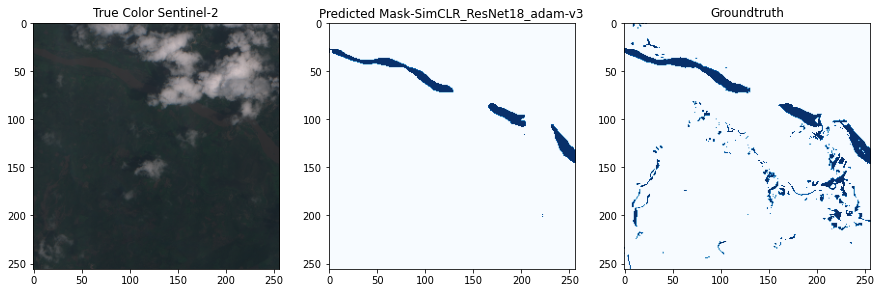

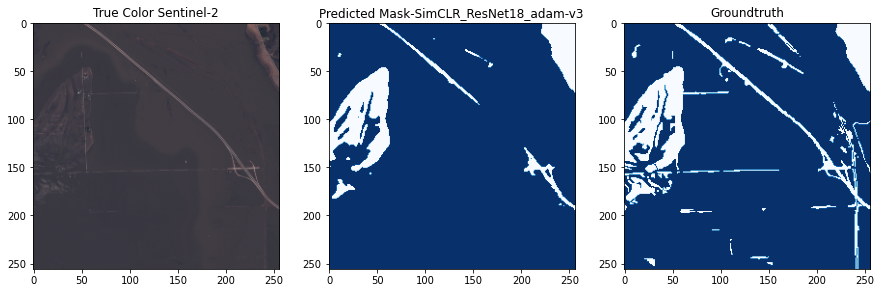

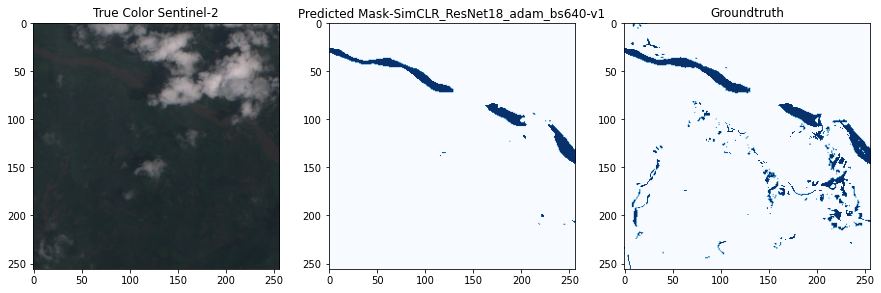

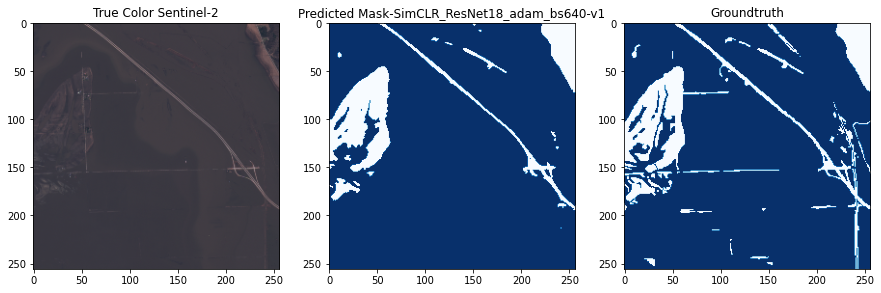

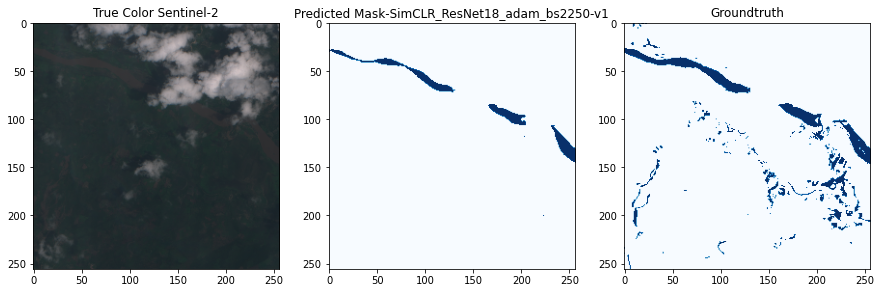

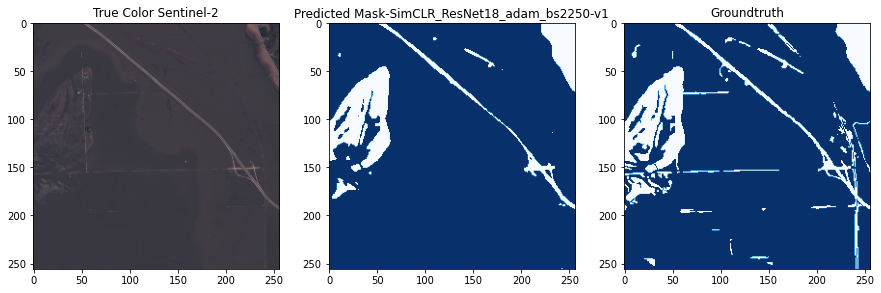

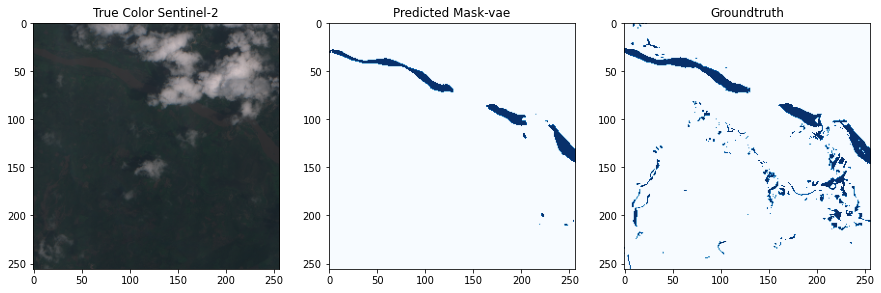

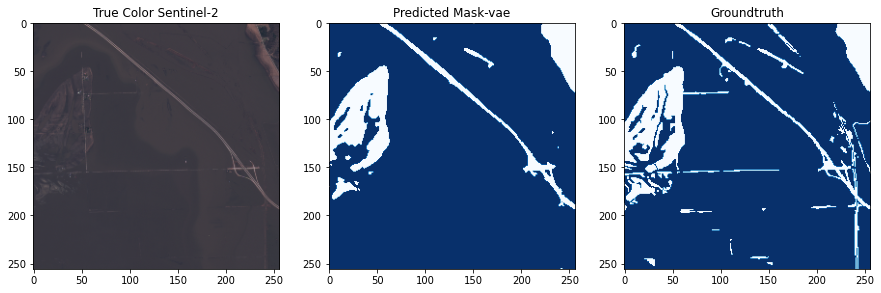

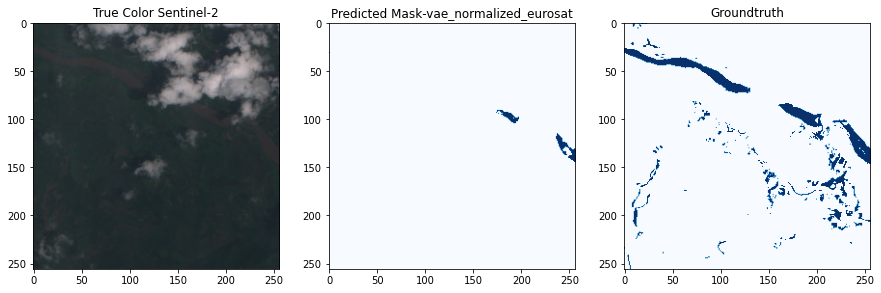

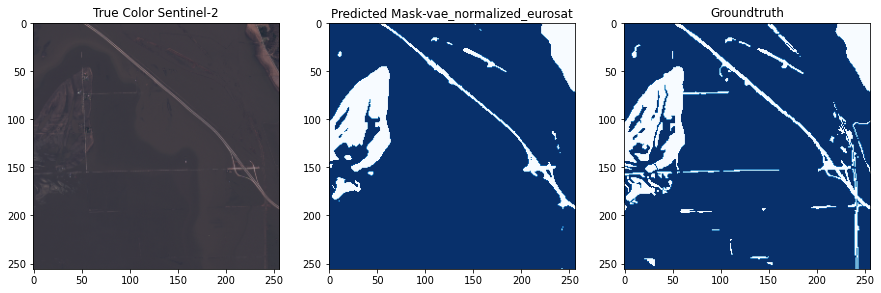

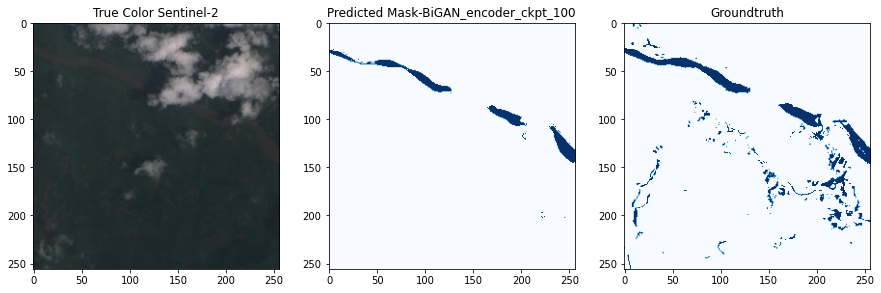

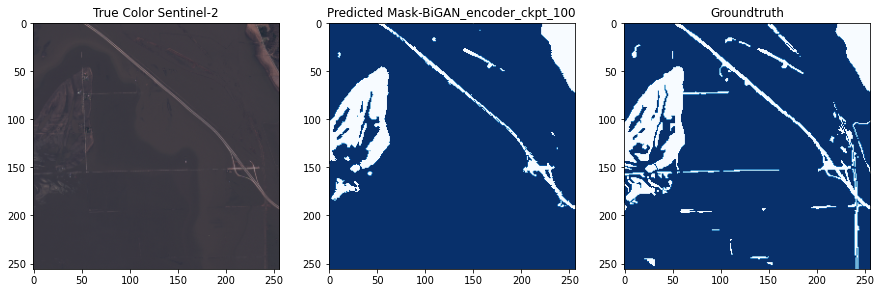

In [28]:
for filename in check_point_paths:
    # Update checkpoint name
    train_config.checkpoint_name = filename
    # Load Encoder from different pre-text architectures
    encoder = load_encoder_checkpoint_from_pretext_model(
        path_to_checkpoint=filename,
    )
    patch_first_conv(encoder,13,default_in_channels=3)

    model_name = filename.split("/")[-1].split(".")[0]
    model_dir = '/content/drive/My Drive/deep_learning_segmentation_checkpoints'
    model_path = os.path.join(model_dir,f'segmentation_{model_name}.ckpt')
    # make sure the directory path exists
    assert os.path.exists(model_dir)
    

    wandb.init(
        project="ssl-remote-sensing-segmentation",
        name=model_name,
        config=train_config.__dict__,
    )

    # Model setup
    if "bigan" in train_config.checkpoint_name.lower():
        model = ResNetUNet(1,encoder = encoder, gan_encoder=True)
    else:
        model = ResNetUNet(1, encoder = encoder, gan_encoder=False)

    # Initialise the optimizer
    if train_config.optim == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif train_config.optim == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    epochs = train_config.epochs

    # Move the model to the GPU
    model.to(device)

    # Create lists for logging losses and evalualtion metrics:
    train_losses = []
    train_accs = []
    train_ious = []

    val_losses = []
    val_accs = []
    val_ious = []

    # IoU
    jaccard = JaccardIndex(num_classes=2).to(device)


    # For every epoch 
    for epoch in range(epochs):
        epoch_loss = 0
        progress = tqdm(
            enumerate(train_loader), desc="Train Loss: ",
            total=len(train_loader)
        )
        
        # Specify you are in training mode
        model.train()
        
        epoch_train_loss = 0
        epoch_val_loss = 0

        epoch_train_ious = 0
        epoch_val_ious = 0

        epoch_train_accs = 0
        epoch_val_accs = 0

        for i, batch in progress:
            # Transfer data to GPU if available
            data = batch["s2_img"].float().to(device)
            label = batch['mask'].float().to(device)
            
            # Make a forward pass
            output = model(data)
            #print(output.shape)

            # Derive binary segmentation map from prediction
            output_binary = torch.zeros(output.shape)
            output_binary[output >= 0] = 1

            # Compute IoU
            epoch_train_ious += jaccard(output_binary.to(device), label.int()) / len(train_loader)

            # Compute pixel accuracies
            epoch_train_accs += torch.sum(output_binary.to(device) == label.int()) / (len(train_loader) * (256*256) * 100)
            
            # Compute the loss
            loss = criterion(output, label.unsqueeze(1))
            
            # Clear the gradients
            optimizer.zero_grad()

            # Calculate gradients 
            loss.backward()

            # Update Weights
            optimizer.step()
            
            # Accumulate the loss over the eopch
            epoch_train_loss += loss / len(train_loader)

            progress.set_description("Epoch = {}, Train Loss: {:.4f}".format(epoch+1,
                                        epoch_train_loss))

        progress = tqdm(
            enumerate(val_loader), desc="val Loss: ",
            total=len(val_loader), position=0, leave=True,)
        
        # Specify you are in evaluation mode
        model.eval()
        
        # Deactivate autograd engine (no backpropagation allowed)
        with torch.no_grad():
            epoch_val_loss = 0
            for j, batch in progress:
                # Transfer Data to GPU if available
                data = batch["s2_img"].float().to(device)
                label = batch['mask'].float().to(device)

                # Make a forward pass
                output = model(data)

                # Derive binary segmentation map from prediction
                output_binary = torch.zeros(output.shape)
                output_binary[output >= 0] = 1

                # Compute IoU
                epoch_val_ious += jaccard(output_binary.to(device), label.int()) / len(val_loader)

                # Compute pixel accuracies
                epoch_val_accs += torch.sum(output_binary.to(device) == label.int()) / (len(val_loader) * (256*256) * 100)
                
                # Compute the loss
                val_loss = criterion(output, label.unsqueeze(1))
                        
                # Accumulate the loss over the epoch
                epoch_val_loss += val_loss / len(val_loader)

                progress.set_description("Validation Loss: {:.4f}".format(
                                        epoch_val_loss))
        
        if epoch == 0:
            best_val_loss = epoch_val_loss
        else:
            if epoch_val_loss <= best_val_loss:
                best_val_loss = epoch_val_loss
                # Save only the best model
                torch.save(model.state_dict(), model_path)
                print('Saving Model...')

        # save result to wandb
        wandb.log({'train_loss_segmentation': epoch_train_loss, 'val_loss_segmentation': epoch_val_loss, 
                  'train_iou_segmentation': epoch_train_ious, 'val_iou_segmentation':epoch_val_ious,
                   'train_acc_segmentation': epoch_train_accs, 'val_acc_segmentation':epoch_val_accs})

        # print("Epoch = ", epoch+1)
        # Save losses in list, so that we can visualise them later. 
        train_losses.append(epoch_train_loss.cpu().detach().numpy())
        val_losses.append(epoch_val_loss.cpu().detach().numpy())

        # Save IoUs in list, so that we can visualise them later. 
        train_ious.append(epoch_train_ious.cpu().detach().numpy())
        val_ious.append(epoch_val_ious.cpu().detach().numpy())
        print(f'train_iou is {epoch_train_ious:.4f}, val_iou is {epoch_val_ious:.4f}')

        # Save accuracies in list, so that we can visualise them later. 
        train_accs.append(epoch_train_accs.cpu().detach().numpy())
        val_accs.append(epoch_val_accs.cpu().detach().numpy())
        print(f'train_acc is {epoch_train_accs:.4f}, val_acc is {epoch_val_accs:.4f}')

    print('Finished Training')

    # Initialise a UNet() model 
    if "bigan" in train_config.checkpoint_name.lower():
        model = ResNetUNet(1,encoder = encoder, gan_encoder=True)
    else:
        model = ResNetUNet(1, encoder = encoder, gan_encoder=False)
    # Load pretrained weights
    model.load_state_dict(torch.load(model_path))
    # Move to device (GPU or CPU)
    model.to(device);

    def display_outputs(idx=None, multi=False):
    # Pick a random index if none is specified
        if not idx:
            idx = random.randint(0, len(valset))
        print('Validation image ID: {}'.format(idx))
        
        # Get Sentinel 2 and Sentinel 1 data
        s2_data = torch.unsqueeze(valset.__getitem__(idx)['s2_img'].float().to(device), 0)
        s1_data = torch.unsqueeze(valset.__getitem__(idx)['s1_img'].float().to(device), 0)
        
        # Get predictions from the model
        if multi:
            output = model(s1_data, s2_data)
        else:
            output = model(s2_data)
        
        # Threshold the output to generate the binary map (FYI: the threshold value "0" can be tuned as any other hyperparameter)
        output_binary = torch.zeros(output.shape)
        output_binary[output >= 0] = 1
        
        get_metrics(valset.__getitem__(idx)['mask'], output_binary)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 7))
        axes[0].imshow(np.transpose(valset.__getitem__(idx)['s2_img'][[3,2,1],:,:], (1, 2, 0)) / valset.__getitem__(idx)['s2_img'].max())
        axes[0].set_title('True Color Sentinel-2')
        axes[2].imshow(valset.__getitem__(idx)['mask'], cmap='Blues')
        axes[2].set_title(f'Groundtruth')
        axes[1].imshow(output_binary.squeeze(), cmap='Blues')
        axes[1].set_title(f'Predicted Mask-{model_name}')

    print("Sample image: ", model_name)
    display_outputs(37)
    display_outputs(127)

Function copied from: https://github.com/qubvel/segmentation_models.pytorch